# BT4012 Assignment one: Bayesian Linear Regression.

**What is the role of prior distribution in bayesian analysis?** 


*  **Due on 18 Sep 2020, Friday at 23:59pm**
*  **Submit your solution notebook to "LumiNUS -> Files->HW1-Assignment**
*  **Prepend your NUS userID to the filename, i.e., "`a0123456_BT4012_AssignmentI.ipynb`"**

In [ ]:
from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/content/drive')

In [24]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
np.random.seed(123)
# Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['figure.figsize'] = (5, 5)
import seaborn as sns
from IPython.core.pylabtools import figsize
# Scipy helper functions
from scipy.stats import percentileofscore
from scipy import stats

In [25]:
# Standard ML Models for comparison
from sklearn.linear_model import LinearRegression
# Splitting data into training/testing
from sklearn.model_selection import train_test_split

## 1. Simple Linear Regression (3 points)

You will work with the student grade dataset. For simplicity, only two features including **Medu** and **studytime** are considered and the target variable is still the G3 column that will be renamed to Grade. You will build linear regression model and check the model parameters first.  

### Load the data


In [26]:
df_data = pd.read_csv("C:\\Users\\lskel\\Downloads\\student-mat.csv", sep=';', index_col=None)

In [27]:
df_data.rename(columns={'G3': 'Grade'}, inplace=True)
df_data = df_data[~df_data['Grade'].isin([0, 1])]
df_used = df_data[['studytime', 'Medu', 'Grade']]

In [28]:
df_used.head(2)

,studytime,Medu,Grade
0,2,4,6
1,2,1,6


In [29]:
df_X = df_used[['studytime', 'Medu']] #store features
df_y = df_used[['Grade']]

In [30]:
 # Split into training/testing sets with 25% split
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, 
                                                    test_size = 0.25,
                                                    random_state=123)

### *Train linear regression model on X_train and y_train*

* Adopt the default hyperparamter setting 


In [31]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

### *Check MAE and RMSE on testing data*

In [32]:
# Metrics
predictions = lr.predict(X_test)
mae = np.mean(abs(predictions - y_test))
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
print('Using Linear Regression, MAE is %0.2f' %  mae)  
print('Using Linear Regression, MAE is %0.2f' %  rmse)  

Using Linear Regression, MAE is 2.84
Using Linear Regression, MAE is 3.45


### *Check the predicted grade of one student*

The 10th student in the testing data

In [60]:
preddf = pd.DataFrame(predictions)
preddf.iloc[9,0]

11.991945845627459

In [62]:
testdf = pd.DataFrame(y_test)
testdf.iloc[9,0]

15

### *Print the learned model parameters of linear regression*

You could get the function directly that describes the dependency between features and label. And try to explain the learned parameters.

In [34]:
ols_formula = 'Grade = %0.2f +' % lr.intercept_
for i, col in enumerate(X_train.columns):
    ols_formula += ' %0.2f * %s +' % (lr.coef_[0][i], col)
    
print(' '.join(ols_formula.split(' ')[:-1]))

##studytime has more effect on grades compared to mother education

Grade = 8.75 + 0.68 * studytime + 0.47 * Medu


## 2. Bayesian Linear Regression (7 points)

You are going to work with a bayesian linear regression. Here, two bayesian models will be implemented with **two different sets of prior functions**. The first bayeisan model is given as:

$u_i = \beta_0 + \beta_1*{studytime}_i + \beta_2*{medu}_i$

$grade_i \sim Norm(u_i, \sigma^2_\epsilon)$

$\beta_0 \sim Norm(0, 1)$

$\beta_1 \sim Norm(0, 1)$

$\beta_2 \sim Norm(0, 100)$

$\sigma_\epsilon \sim {Uniform}(0, 10)$

Here, $\beta_0$ is the intercept. Then, $\beta_1$ and $\beta_2$ are the coefficients for features: studytime and medu.  For the i-th datasample, a mean $u_i$ can be computed linearly from two features. Then, the target grade $y_i$ is assumed to be normally distributed around this $u_i$.

##### Make sure the version of pymc3 is 3.8

In [35]:
! pip install pymc3==3.8

In [36]:
import pymc3 as pm

In [37]:
def model_build(df_train, df_label=None):
  """
  build genearlized linear model
  """
  with pm.Model() as model:
    sigma = pm.Uniform('sigma', 0, 10) #the error term is an uniform distribution
    num_fea = df_train.shape[1]
    mu_infe = pm.Normal('intercept', mu=0, sigma=1) #the bias term is an normal distribution (mean=0, sigma=10)
    mu_infe = mu_infe + pm.Normal('coeff_for_{}'.format(df_train.columns[0]), mu=0, sigma=1)*df_train.loc[:, df_train.columns[0]]
    mu_infe = mu_infe + pm.Normal('coeff_for_{}'.format(df_train.columns[1]), mu=0, sigma=10)*df_train.loc[:, df_train.columns[1]]
    if df_label is None:
      # inference
      likelihood = pm.Normal('y', mu=mu_infe, sigma=sigma, observed = False)
    else:
      # training
      likelihood = pm.Normal('y', mu=mu_infe, sigma=sigma, observed = df_label['Grade'].values)
    return model

In [38]:
# Use MCMC algorithm to draw samples to approximate the posterior for model parameters (error term, bias term and all coefficients)
with model_build(X_train, y_train):
    trace = pm.sample(draws=2000, chains = 2, tune = 500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [coeff_for_Medu, coeff_for_studytime, intercept, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [21:20<00:00,  3.90draws/s]


In [39]:
# sample the posterior predictive distribution for the 10th student in testing data
# 4000 samples (2 chains and each chain has 2000 samples) will be sampled for this student.
with model_build(X_test.iloc[9:10,:]):
    ppc = pm.sample_posterior_predictive(trace)

100%|██████████| 4000/4000 [00:04<00:00, 932.28it/s] 


*Compute the mean and standard deviation of your prediction.*

In [40]:
## write your code
print(np.mean(ppc["y"]))
print(np.std(ppc["y"]))

12.420817841136701
3.1687323339000297


### *Check the posterior distribution for the model parameters*

$p(w|D)$

In [41]:
print(pm.summary(trace).round(5))

C:\Users\lskel\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
intercept            6.052  0.597   4.929    7.115      0.013    0.009   
coeff_for_studytime  1.184  0.211   0.792    1.574      0.004    0.003   
coeff_for_Medu       0.989  0.177   0.653    1.318      0.004    0.003   
sigma                3.170  0.143   2.909    3.444      0.003    0.002   

                     ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
intercept              2239.0  2234.0    2244.0    2242.0    1.0  
coeff_for_studytime    2526.0  2526.0    2523.0    2112.0    1.0  
coeff_for_Medu         2275.0  2194.0    2290.0    2075.0    1.0  
sigma                  2753.0  2719.0    2816.0    2151.0    1.0  


In [42]:
def plot_trace(trace):
    # Traceplot with vertical lines at the mean value
    ax = pm.traceplot(trace, figsize=(14, len(trace.varnames)*1.8),
                      lines={k: v['mean'] for k, v in pm.summary(trace).iterrows()})
    
    matplotlib.rcParams['font.size'] = 16
    
    # Labels with the median value
    for i, mn in enumerate(pm.summary(trace)['mean']):
        ax[i, 0].annotate('{:0.2f}'.format(mn), xy = (mn, 0), xycoords = 'data', size = 8,
                          xytext = (-18, 18), textcoords = 'offset points', rotation = 90,
                          va = 'bottom', fontsize = 'large', color = 'red')

C:\Users\lskel\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\lskel\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\lskel\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\traceplot.py:150: UserWarning: A valid var_name should be provided, found {'i', 'c', 's'} expected from {'coeff_for_studytime', 'sigma', 'coeff_for_Medu', 'intercept'}
  warnings.warn(
C:\Users\lskel\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarn

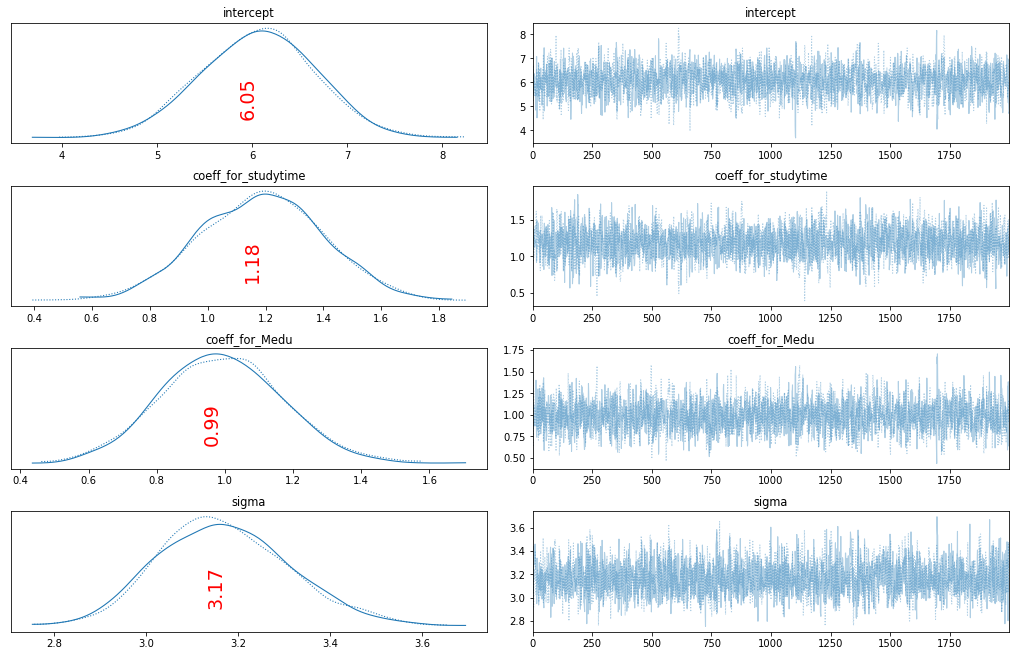

In [43]:
plot_trace(trace);

C:\Users\lskel\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027B4E10E100>,
      dtype=object)

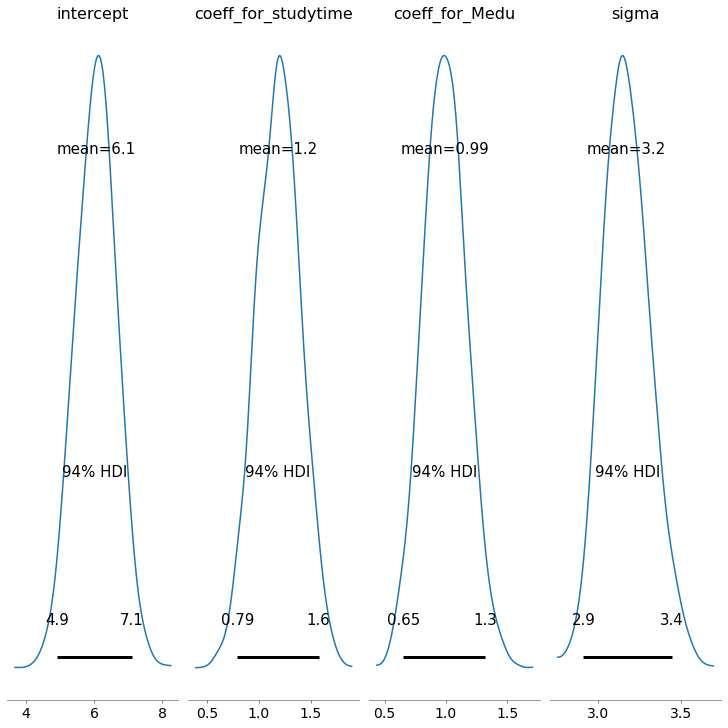

In [44]:
pm.plot_posterior(trace, figsize = (10, 10))

The other bayeisan model is given as:

$u_i = \beta_0 + \beta_1*{studytime}_i + \beta_2*{medu}_i$

$grade_i \sim Norm(u_i, \sigma^2_\epsilon)$

$\beta_0 \sim Norm(0, 100)$

$\beta_1 \sim Norm(0, 100)$

$\beta_2 \sim Norm(0, 100)$

$\sigma_\epsilon \sim {Uniform}(0, 10)$

In [45]:
def model_build(df_train, df_label=None):
  """
  build genearlized linear model
  """
  with pm.Model() as model:
    sigma = pm.Uniform('sigma', 0, 10) #the error term is an uniform distribution
    num_fea = df_train.shape[1]
    mu_infe = pm.Normal('intercept', mu=0, sigma=10) #the bias term is an normal distribution (mean=0, sigma=10)
    for idx in range(num_fea):
      mu_infe = mu_infe + pm.Normal('coeff_for_{}'.format(df_train.columns[idx]), mu=0, sigma=10)*df_train.loc[:, df_train.columns[idx]]  #the coefficient term for each feature is an normal distribution (mean=0, sigma=1)
    if df_label is None:
      # inference
      likelihood = pm.Normal('y', mu=mu_infe, sigma=sigma, observed = False)
    else:
      # training
      likelihood = pm.Normal('y', mu=mu_infe, sigma=sigma, observed = df_label['Grade'].values)
    return model

In [46]:
# Use MCMC algorithm to draw samples to approximate the posterior for model parameters (error term, bias term and all coefficients)
with model_build(X_train, y_train):
    trace = pm.sample(draws=2000, chains = 2, tune = 500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [coeff_for_Medu, coeff_for_studytime, intercept, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [24:05<00:00,  3.46draws/s]


### *Similar to the first bayesian linear regression model, check the distribution for model parameters and the prediction distribution of the previous chosen data sample*

In [47]:
print(pm.summary(trace).round(5))

C:\Users\lskel\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
intercept            8.707  0.680   7.472   10.034      0.015    0.011   
coeff_for_studytime  0.691  0.225   0.247    1.085      0.005    0.003   
coeff_for_Medu       0.474  0.179   0.171    0.850      0.004    0.003   
sigma                3.074  0.135   2.837    3.352      0.002    0.002   

                     ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
intercept              2059.0  2059.0    2065.0    1869.0    1.0  
coeff_for_studytime    2199.0  2065.0    2190.0    2195.0    1.0  
coeff_for_Medu         2412.0  2240.0    2415.0    2242.0    1.0  
sigma                  3056.0  3047.0    3086.0    2177.0    1.0  


C:\Users\lskel\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\lskel\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\lskel\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\traceplot.py:150: UserWarning: A valid var_name should be provided, found {'i', 'c', 's'} expected from {'coeff_for_studytime', 'sigma', 'coeff_for_Medu', 'intercept'}
  warnings.warn(
C:\Users\lskel\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarn

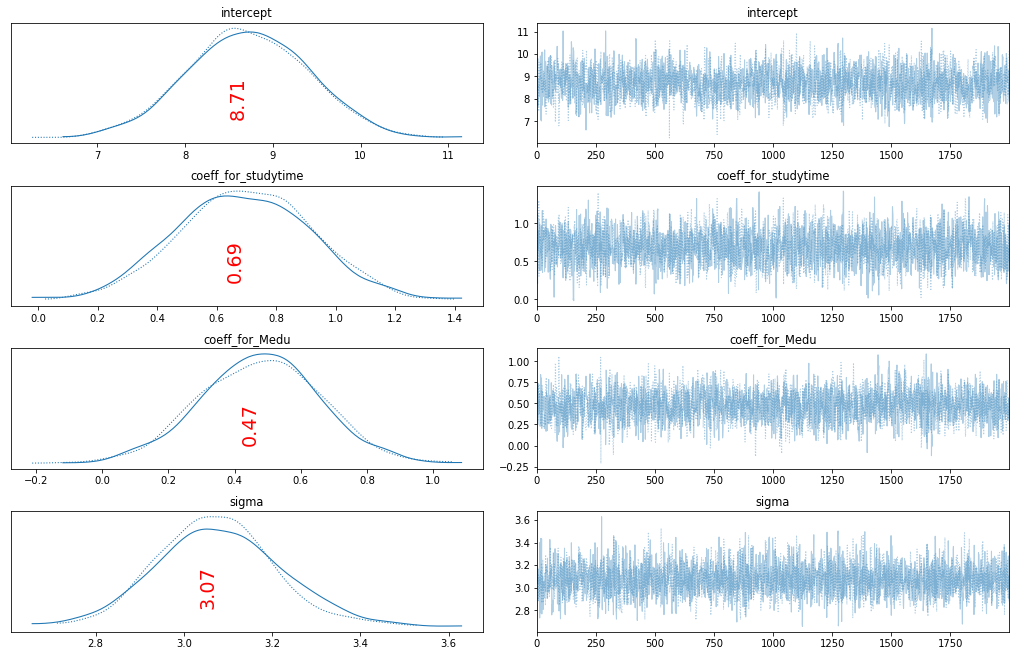

In [48]:
plot_trace(trace);

C:\Users\lskel\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027B4DE5EB20>,
      dtype=object)

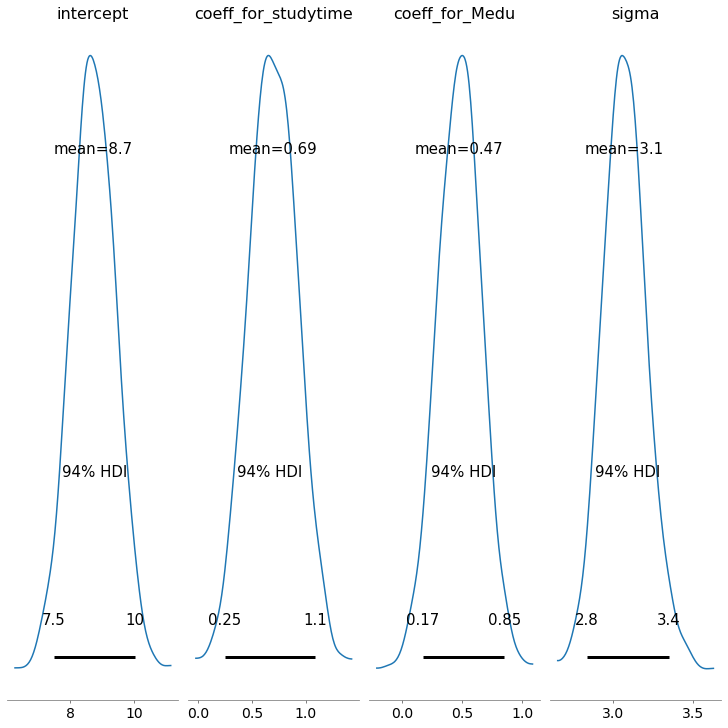

In [49]:
pm.plot_posterior(trace, figsize = (10, 10))

## 3. Compare Bayesian Linear Regression and Linear Regression (5 points)

In the above, you have worked with three different models: two bayesian linear regression (bayesian analysis) and one simple linear regression (frequentist analysis). Try to compare the difference between frequentist model and bayesian models. And explain their differences. Pls focus on the learned model parameters and the predicted result of one certain sample (for example, 10th student sample in testing data). And discuss how the specified prior distribution influenece the bayesian analysis? 

##### Write your solution in Markdown format

In low dimensionality like this data, their performance are similar. Pror distribution represents the information about an uncertain parameter hat is combined with the probability distribution of ew data to yield the posterior distribution, which
in turn is used for future inferences and decisions involving theta.


### END